In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torcheval
import fastcore.all as fc
import torch.optim as optim
from operator import attrgetter
from functools import partial
from datasets import load_dataset,load_dataset_builder
from torch.utils.data import DataLoader,default_collate,Dataset
from torcheval.metrics import MulticlassAccuracy,Mean
from copy import copy
from fastprogress import progress_bar,master_bar
from torch.optim.lr_scheduler import ExponentialLR

def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x,device = def_device):
    if isinstance(x,torch.Tensor): return x.to(device)
    else : return type(x)(to_device(o,device) for o in x)

def to_cpu(x):
    if isinstance(x,torch.Tensor): return x.detach().cpu()
    else : return type(x)(to_cpu(o) for o in x)

class Dataloaders():
    def __init__(self,train_dl,valid_dl): self.train,self.valid = train_dl,valid_dl

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

class Callback(): order = 0

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device = device
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        self.lr_mult = lr_mult
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
    
class BaseSchedCB(Callback):
    def __init__(self, sched):
        self.sched = sched
    def before_fit(self, learn): self.sched = self.sched(learn.opt)
    def _step(self,learn): 
        if learn.training: self.sched.step()
    
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs=None, opt_func=optim.SGD):
        self.model = model
        self.dls = dls
        self.loss_func = loss_func
        self.lr = lr
        self.cbs = cbs if cbs else []
        self.opt_func = opt_func

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        if cbs is None: cbs = []
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def run_cbs(self, cbs, method_nm, learn=None):
        for cb in sorted(cbs, key=attrgetter('order')):
            method = getattr(cb, method_nm, None)
            if method is not None: method(learn)

    def callback(self, method_nm): self.run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [12]:
batch_size = 1024

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = T.ToTensor())
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = T.ToTensor())

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# x,y = 'image','label'
# name = "fashion_mnist"
# dsd = load_dataset(name)
# print(x,y)
# train_ds = dsd['train']
# valid_ds = dsd['test']

# def inplace(f):
#     def _f(x):
#         f(x)
#         return x 
#     return _f

# @inplace
# def transform(b): b[x] = [TF.to_tensor(o) for o in b[x]]

# def collate(b):
#     collated_dict = default_collate(b)
#     return collated_dict[x],collated_dict[y]

# train_dl = DataLoader(train_ds.with_transform(transform), batch_size=batch_size, shuffle=True, collate_fn=collate)
# valid_dl = DataLoader(valid_ds.with_transform(transform), batch_size=batch_size, shuffle=False, collate_fn=collate)

In [13]:
def get_model():
    m,nh = 28*28,50
    model = nn.Sequential(nn.Flatten(),nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model

In [14]:
dls = Dataloaders(train_dl,valid_dl)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

{'accuracy': '0.598', 'loss': '1.194', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.738', 'loss': '0.787', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.747', 'loss': '0.717', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.760', 'loss': '0.659', 'epoch': 1, 'train': 'eval'}


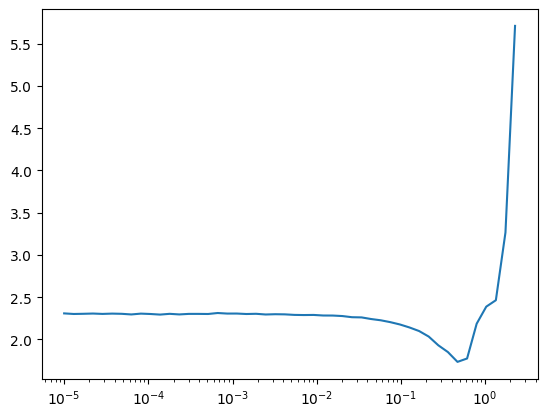

In [19]:
lrfind = LRFinderCB()
cbs = [TrainCB(),DeviceCB(), lrfind]
learn = Learner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')